In [ ]:
# execute to install Python dependencies
# %%capture
# !pip install sf-hamilton[visualization] ipywidgets

# Hamilton caching tutorial
In Hamilton, **caching** broadly refers to "reusing results from previous executions to skip redundant computation". If you change code or pass new data, it will automatically determine which results can be reused and which nodes need to be re-executed. This improves execution speed and reduces resource usage (computation, API credits, etc.).

Throughout this tutorial, we'll be using the Hamilton notebook extension to define dataflows directly in the notebook ([see tutorial](https://github.com/DAGWorks-Inc/hamilton/blob/main/examples/jupyter_notebook_magic/example.ipynb)).

> NOTE. This notebook is on the longer side. We highly suggest using the navigation bar to help.


In [ ]:
from hamilton import driver
# load the notebook extension
%reload_ext hamilton.plugins.jupyter_magic

We import the `logging` module and get the logger from `hamilton.caching`. With the level set to ``INFO``, we'll see ``GET_RESULT`` and ``EXECUTE_NODE`` cache events as they happen.

In [2]:
import logging

logger = logging.getLogger("hamilton.caching")
logger.setLevel(logging.INFO)
logger.addHandler(logging.StreamHandler())

## Basics

We use the cell magic ``%%cell_to_module`` to convert the content of the cell into a Python module that Hamilton can load. The flag ``--display`` will output a visualization of the dataflow.

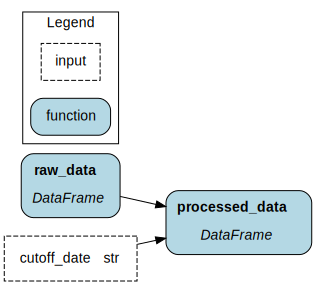

In [3]:
%%cell_to_module module_1 --display
import pandas as pd

DATA = {
    "cities": ["New York", "Los Angeles", "Chicago", "Montréal", "Vancouver"],
    "date": ["2024-09-13", "2024-09-12", "2024-09-11", "2024-09-11", "2024-09-09"],
    "amount": [478.23, 251.67, 989.34, 742.14, 584.56],
    "country": ["USA", "USA", "USA", "Canada", "Canada"],
    "currency": ["USD", "USD", "USD", "CAD", "CAD"],
}

def raw_data() -> pd.DataFrame:
    """Loading raw data. This simulates loading from a file, database, or external service."""
    return pd.DataFrame(DATA)

def processed_data(raw_data: pd.DataFrame, cutoff_date: str) -> pd.DataFrame:
    """Filter out rows before cutoff date and convert currency to USD."""
    df = raw_data.loc[raw_data.date > cutoff_date].copy()
    df["amound_in_usd"] = df["amount"]
    df.loc[df.country == "Canada", "amound_in_usd"] *= 0.73
    return df

Then, we build the ``Driver`` with caching enabled and execute the dataflow.

In [4]:
dr1 = driver.Builder().with_modules(module_1).with_cache().build()

results = dr1.execute(["processed_data"], inputs={"cutoff_date": "2024-09-01"})
print()
print(results["processed_data"].head())

raw_data::adapter::execute_node
processed_data::adapter::execute_node



        cities        date  amount country currency  amound_in_usd
0     New York  2024-09-13  478.23     USA      USD       478.2300
1  Los Angeles  2024-09-12  251.67     USA      USD       251.6700
2      Chicago  2024-09-11  989.34     USA      USD       989.3400
3     Montréal  2024-09-11  742.14  Canada      CAD       541.7622
4    Vancouver  2024-09-09  584.56  Canada      CAD       426.7288


We can view what values were retrieved from the cache using `dr.cache.view_run()`. Since this was the first execution, nothing is retrieved.

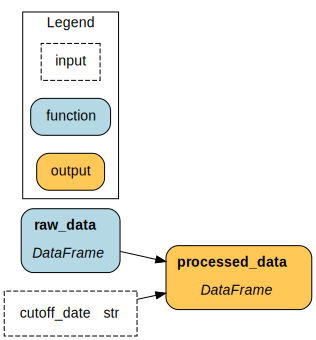

In [5]:
dr1.cache.view_run()

Since no code nor data changed, the results for both nodes will be retrieved.

raw_data::result_store::get_result::hit
processed_data::result_store::get_result::hit



        cities        date  amount country currency  amound_in_usd
0     New York  2024-09-13  478.23     USA      USD       478.2300
1  Los Angeles  2024-09-12  251.67     USA      USD       251.6700
2      Chicago  2024-09-11  989.34     USA      USD       989.3400
3     Montréal  2024-09-11  742.14  Canada      CAD       541.7622
4    Vancouver  2024-09-09  584.56  Canada      CAD       426.7288



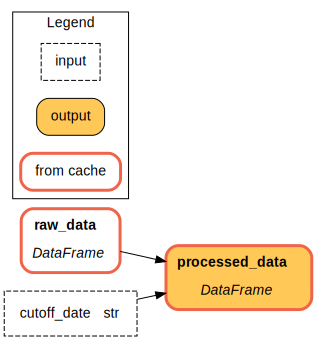

In [6]:
results = dr1.execute(["processed_data"], inputs={"cutoff_date": "2024-09-01"})
print()
print(results["processed_data"].head())
print()
dr1.cache.view_run()

## Adding a node
We copy the previous module into a new module named `module_2` and define the node `amount_per_country`.

> In practice, you would edit the cell directly, but this makes the notebook easier to read and maintain

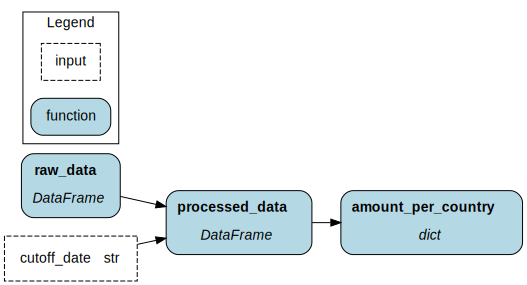

In [7]:
%%cell_to_module module_2 --display
import pandas as pd

DATA = {
    "cities": ["New York", "Los Angeles", "Chicago", "Montréal", "Vancouver"],
    "date": ["2024-09-13", "2024-09-12", "2024-09-11", "2024-09-11", "2024-09-09"],
    "amount": [478.23, 251.67, 989.34, 742.14, 584.56],
    "country": ["USA", "USA", "USA", "Canada", "Canada"],
    "currency": ["USD", "USD", "USD", "CAD", "CAD"],
}

def raw_data() -> pd.DataFrame:
    """Loading raw data. This simulates loading from a file, database, or external service."""
    return pd.DataFrame(DATA)

def processed_data(raw_data: pd.DataFrame, cutoff_date: str) -> pd.DataFrame:
    """Filter out rows before cutoff date and convert currency to USD."""
    df = raw_data.loc[raw_data.date > cutoff_date].copy()
    df["amound_in_usd"] = df["amount"]
    df.loc[df.country == "Canada", "amound_in_usd"] *= 0.73
    return df

def amount_per_country(processed_data: pd.DataFrame) -> dict:
    """Sum the amount in USD per country"""
    return processed_data.groupby("country")["amound_in_usd"].sum()

We build a new `Driver` with `module_2` and execute the dataflow. You'll notice that `raw_data` and `processed_data` are retrieved and only `amount_per_country` is executed.

raw_data::result_store::get_result::hit
processed_data::result_store::get_result::hit
amount_per_country::adapter::execute_node



country
Canada     968.491
USA       1719.240
Name: amound_in_usd, dtype: float64



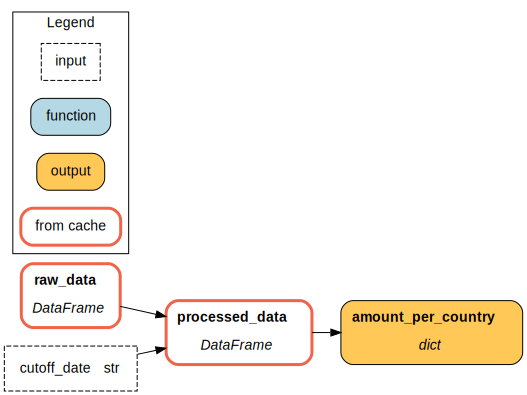

In [8]:
dr2 = driver.Builder().with_modules(module_2).with_cache().build()

results = dr2.execute(["amount_per_country"], inputs={"cutoff_date": "2024-09-01"})
print()
print(results["amount_per_country"].head())
print()
dr2.cache.view_run()

Even though `raw_data` and `processed_data` were initially executed in `module_1`, they can be retrieved because they have the same code! This means you can reuse cached results across dataflows. This is particularly useful with training and inference machine learning pipelines.

## Changing inputs
Changing the input `cutoff_date` from `"2024-09-01"` to `"2024-09-11"` will force `processed_data` to be re-executed. Since the new cutoff changed the result of `processed_data`, the cascade also forced `amount_per_country` to be re-executed.

raw_data::result_store::get_result::hit
processed_data::adapter::execute_node
amount_per_country::adapter::execute_node



country
USA    729.9
Name: amound_in_usd, dtype: float64



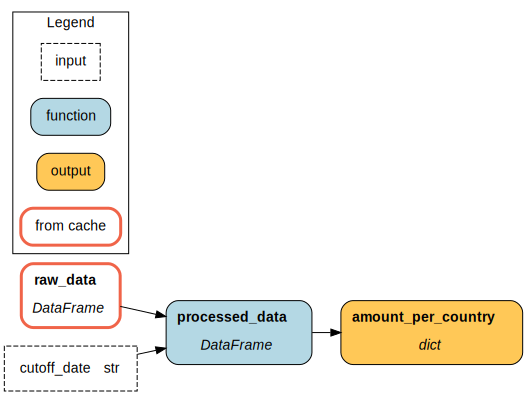

In [9]:
results = dr2.execute(["amount_per_country"], inputs={"cutoff_date": "2024-09-11"})
print()
print(results["amount_per_country"].head())
print()
dr2.cache.view_run()

On the other hand, changing the `cutoff_date` to `"2024-09-05"` will force `processed_data` to be executed, but `amount_per_country` is still retrieved. This is because the result of `processed_data` is equivalent to a previous run. No need for these redundant computations then!

raw_data::result_store::get_result::hit
processed_data::adapter::execute_node
amount_per_country::result_store::get_result::hit



country
Canada     968.491
USA       1719.240
Name: amound_in_usd, dtype: float64



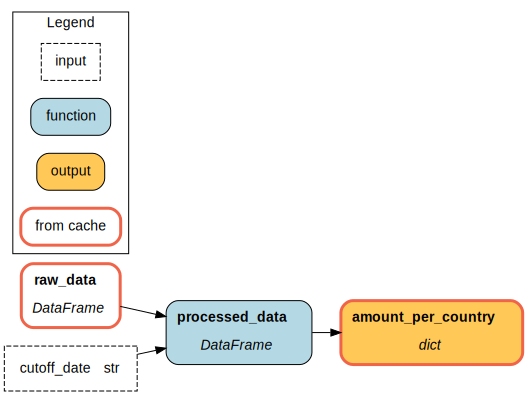

In [10]:
results = dr2.execute(["amount_per_country"], inputs={"cutoff_date": "2024-09-05"})
print()
print(results["amount_per_country"].head())
print()
dr2.cache.view_run()

## Changing code
As you develop your dataflow, you will need to edit upstream nodes. Caching will automatically detect code changes and determine which node needs to be re-executed. In `processed_data()`, we'll change the conversation rate from `0.73` to `0.71`.

> NOTE. changes to docstrings and comments `#` are ignored when versioning a node.

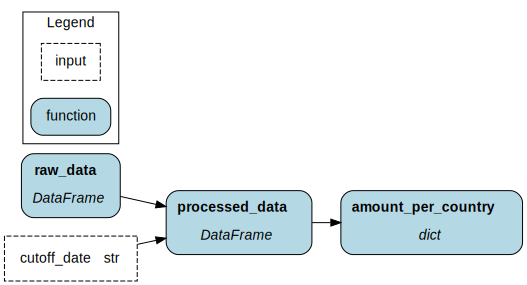

In [11]:
%%cell_to_module module_3 --display
import pandas as pd

DATA = {
    "cities": ["New York", "Los Angeles", "Chicago", "Montréal", "Vancouver"],
    "date": ["2024-09-13", "2024-09-12", "2024-09-11", "2024-09-11", "2024-09-09"],
    "amount": [478.23, 251.67, 989.34, 742.14, 584.56],
    "country": ["USA", "USA", "USA", "Canada", "Canada"],
    "currency": ["USD", "USD", "USD", "CAD", "CAD"],
}

def raw_data() -> pd.DataFrame:
    """Loading raw data. This simulates loading from a file, database, or external service."""
    return pd.DataFrame(DATA)

def processed_data(raw_data: pd.DataFrame, cutoff_date: str) -> pd.DataFrame:
    """Filter out rows before cutoff date and convert currency to USD."""
    df = raw_data.loc[raw_data.date > cutoff_date].copy()
    df["amound_in_usd"] = df["amount"]
    df.loc[df.country == "Canada", "amound_in_usd"] *= 0.71  # <- VALUE CHANGED FROM module_2
    return df

def amount_per_country(processed_data: pd.DataFrame) -> dict:
    """Sum the amount in USD per country"""
    return processed_data.groupby("country")["amound_in_usd"].sum()

During execution, `processed_data` needs to be re-executed because its code changed. The downstream `amount_per_country` is re-executed because the input data returned by `processed_data` changed.

raw_data::result_store::get_result::hit
processed_data::adapter::execute_node
amount_per_country::adapter::execute_node



country
Canada     941.957
USA       1719.240
Name: amound_in_usd, dtype: float64



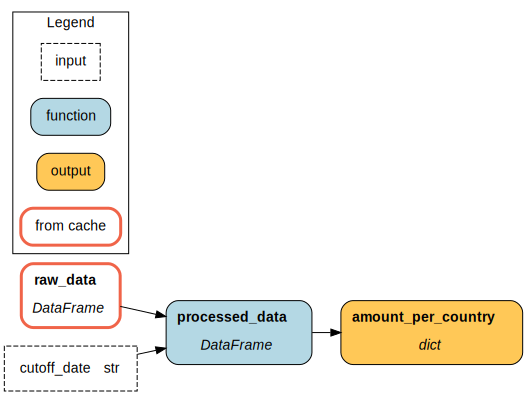

In [12]:
dr3 = driver.Builder().with_modules(module_3).with_cache().build()

results = dr3.execute(["amount_per_country"], inputs={"cutoff_date": "2024-09-01"})
print()
print(results["amount_per_country"].head())
print()
dr3.cache.view_run()

Now, we want to make a change to `processed_data` to accomodate currency conversion for Brazil and Mexico. This is another code change.

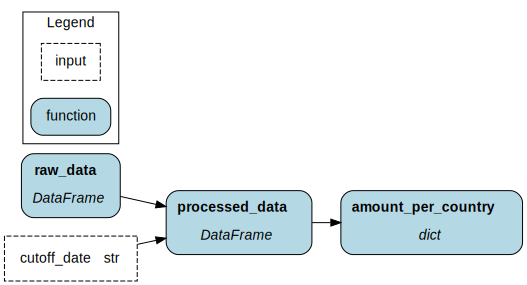

In [13]:
%%cell_to_module module_4 --display
import pandas as pd

DATA = {
    "cities": ["New York", "Los Angeles", "Chicago", "Montréal", "Vancouver"],
    "date": ["2024-09-13", "2024-09-12", "2024-09-11", "2024-09-11", "2024-09-09"],
    "amount": [478.23, 251.67, 989.34, 742.14, 584.56],
    "country": ["USA", "USA", "USA", "Canada", "Canada"],
    "currency": ["USD", "USD", "USD", "CAD", "CAD"],
}

def raw_data() -> pd.DataFrame:
    """Loading raw data. This simulates loading from a file, database, or external service."""
    return pd.DataFrame(DATA)

def processed_data(raw_data: pd.DataFrame, cutoff_date: str) -> pd.DataFrame:
    """Filter out rows before cutoff date and convert currency to USD."""
    df = raw_data.loc[raw_data.date > cutoff_date].copy()
    df["amound_in_usd"] = df["amount"]
    df.loc[df.country == "Canada", "amound_in_usd"] *= 0.71  
    df.loc[df.country == "Brazil", "amound_in_usd"] *= 0.18  # <- LINE ADDED
    df.loc[df.country == "Mexico", "amound_in_usd"] *= 0.05  # <- LINE ADDED
    return df

def amount_per_country(processed_data: pd.DataFrame) -> dict:
    """Sum the amount in USD per country"""
    return processed_data.groupby("country")["amound_in_usd"].sum()

The code change to `processed_data` forced its execution. However, since it returned a value previously seen, the result for `amount_per_country` can be retrieved directly. 

raw_data::result_store::get_result::hit
processed_data::adapter::execute_node
amount_per_country::result_store::get_result::hit



country
Canada     941.957
USA       1719.240
Name: amound_in_usd, dtype: float64



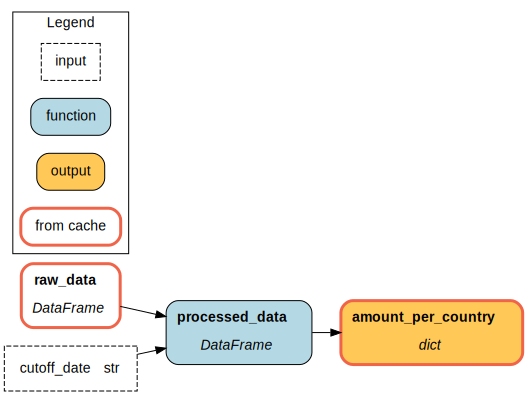

In [14]:
dr4 = driver.Builder().with_modules(module_4).with_cache().build()

results = dr4.execute(["amount_per_country"], inputs={"cutoff_date": "2024-09-01"})
print()
print(results["amount_per_country"].head())
print()
dr4.cache.view_run()

## Changing external data
Similarly to the **Changing inputs** section, we will modify the `DATA` constant. This simulates `raw_data` loading new data from a database or external service.   

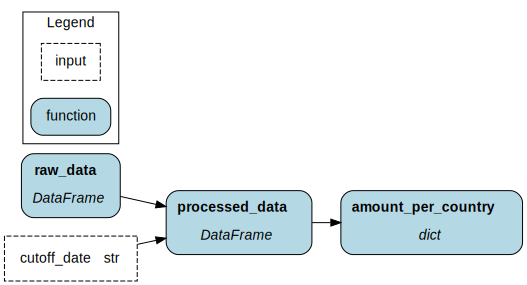

In [15]:
%%cell_to_module module_5 --display
import pandas as pd

DATA = {
    "cities": ["New York", "Los Angeles", "Chicago", "Montréal", "Vancouver", "Houston", "Phoenix", "Mexico City", "Chihuahua City", "Rio de Janeiro"],
    "date": ["2024-09-13", "2024-09-12", "2024-09-11", "2024-09-11", "2024-09-09", "2024-09-08", "2024-09-07", "2024-09-06", "2024-09-05", "2024-09-04"],
    "amount": [478.23, 251.67, 989.34, 742.14, 584.56, 321.85, 918.67, 135.22, 789.12, 432.78],
    "country": ["USA", "USA", "USA", "Canada", "Canada", "USA", "USA", "Mexico", "Mexico", "Brazil"],
    "currency": ["USD", "USD", "USD", "CAD", "CAD", "USD", "USD", "MXN", "MXN", "BRL"],
}

def raw_data() -> pd.DataFrame:
    """Loading raw data. This simulates loading from a file, database, or external service."""
    return pd.DataFrame(DATA)

def processed_data(raw_data: pd.DataFrame, cutoff_date: str) -> pd.DataFrame:
    """Filter out rows before cutoff date and convert currency to USD."""
    df = raw_data.loc[raw_data.date > cutoff_date].copy()
    df["amound_in_usd"] = df["amount"]
    df.loc[df.country == "Canada", "amound_in_usd"] *= 0.71  
    df.loc[df.country == "Brazil", "amound_in_usd"] *= 0.18
    df.loc[df.country == "Mexico", "amound_in_usd"] *= 0.05
    return df

def amount_per_country(processed_data: pd.DataFrame) -> dict:
    """Sum the amount in USD per country"""
    return processed_data.groupby("country")["amound_in_usd"].sum()

When executing this dataflow, Hamilton sees the same code for all nodes and `inputs` previously seen. It can't automatically determine that external data changed (i.e., `DATA`). When executing, you'll see that it incorrectly behaves 🚧. It will reload `raw_data` from cache and won't cascade re-execution.

raw_data::result_store::get_result::hit
processed_data::result_store::get_result::hit
amount_per_country::result_store::get_result::hit



country
Canada     941.957
USA       1719.240
Name: amound_in_usd, dtype: float64



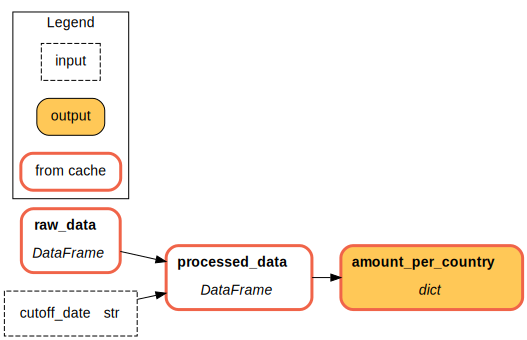

In [16]:
dr5 = driver.Builder().with_modules(module_5).with_cache().build()

results = dr5.execute(["amount_per_country"], inputs={"cutoff_date": "2024-09-01"})
print()
print(results["amount_per_country"].head())
print()
dr5.cache.view_run()

### `.with_cache()` to specify caching behavior
Here, we build a new `Driver` with the same `module_5`, but we specify in `.with_cache()` to always recompute `raw_data`. Then, downstream nodes will automatically determine if they need to be re-executed, as usual.

The visualization tells us `raw_data` was re-executed and the dataflow responded correctly. Also, the printed results include the new countries: Canada, Brazil, and Mexico.

raw_data::adapter::execute_node
processed_data::adapter::execute_node
amount_per_country::adapter::execute_node



country
Brazil      77.9004
Canada     941.9570
Mexico      46.2170
USA       2959.7600
Name: amound_in_usd, dtype: float64



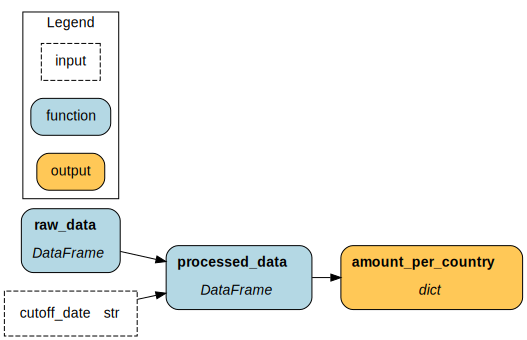

In [17]:
dr6 = driver.Builder().with_modules(module_5).with_cache(recompute=["raw_data"]).build()

results = dr6.execute(["amount_per_country"], inputs={"cutoff_date": "2024-09-01"})
print()
print(results["amount_per_country"].head())
print()
dr6.cache.view_run()

### `@cache` to specify caching behavior
The `@cache` decorator allows you to specify the caching behavior directly in the dataflow. This is useful when you know that a node should always be recomputed. This allows all `Driver` to automatically pick up this information.

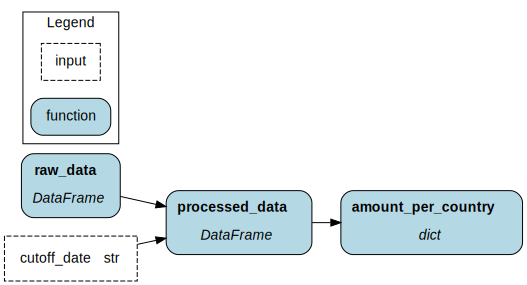

In [18]:
%%cell_to_module module_6 --display
import pandas as pd
from hamilton.function_modifiers import cache

DATA = {
    "cities": ["New York", "Los Angeles", "Chicago", "Montréal", "Vancouver", "Houston", "Phoenix", "Mexico City", "Chihuahua City", "Rio de Janeiro"],
    "date": ["2024-09-13", "2024-09-12", "2024-09-11", "2024-09-11", "2024-09-09", "2024-09-08", "2024-09-07", "2024-09-06", "2024-09-05", "2024-09-04"],
    "amount": [478.23, 251.67, 989.34, 742.14, 584.56, 321.85, 918.67, 135.22, 789.12, 432.78],
    "country": ["USA", "USA", "USA", "Canada", "Canada", "USA", "USA", "Mexico", "Mexico", "Brazil"],
    "currency": ["USD", "USD", "USD", "CAD", "CAD", "USD", "USD", "MXN", "MXN", "BRL"],
}

@cache(behavior="recompute")
def raw_data() -> pd.DataFrame:
    """Loading raw data. This simulates loading from a file, database, or external service."""
    return pd.DataFrame(DATA)

def processed_data(raw_data: pd.DataFrame, cutoff_date: str) -> pd.DataFrame:
    """Filter out rows before cutoff date and convert currency to USD."""
    df = raw_data.loc[raw_data.date > cutoff_date].copy()
    df["amound_in_usd"] = df["amount"]
    df.loc[df.country == "Canada", "amound_in_usd"] *= 0.71  
    df.loc[df.country == "Brazil", "amound_in_usd"] *= 0.18
    df.loc[df.country == "Mexico", "amound_in_usd"] *= 0.05
    return df

def amount_per_country(processed_data: pd.DataFrame) -> dict:
    """Sum the amount in USD per country"""
    return processed_data.groupby("country")["amound_in_usd"].sum()

We now build a `Driver` with `module_4`, which includes the `@cache` decorator and don't specify anything in `.with_cache()` since both are entirely equivalent.	

Interestingly, you can see that `raw_data` is forced to be re-executed, but other results can be retrieved since produced them in the previous cell! 

raw_data::adapter::execute_node
processed_data::result_store::get_result::hit
amount_per_country::result_store::get_result::hit



country
Brazil      77.9004
Canada     941.9570
Mexico      46.2170
USA       2959.7600
Name: amound_in_usd, dtype: float64



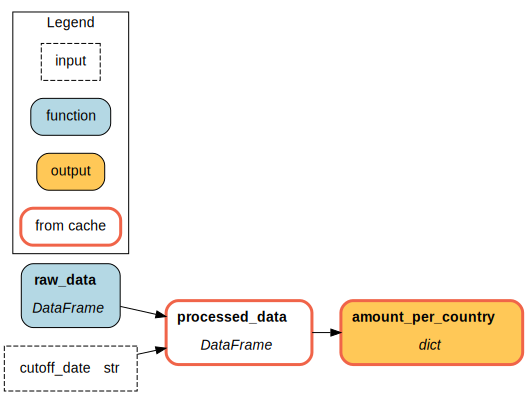

In [19]:
dr7 = driver.Builder().with_modules(module_6).with_cache().build()

results = dr7.execute(["amount_per_country"], inputs={"cutoff_date": "2024-09-01"})
print()
print(results["amount_per_country"].head())
print()
dr7.cache.view_run()

Importantly, `.with_cache(...)` has precedence over whatever is specified in `@cache` because it is closer to execution. For instance, having `.with_cache(default=["raw_data"])` would force default behavior despite `raw_data` having the decorator `@cache(behavior="recompute")`.

### Always recompute materializers
An alternative to specifying caching behavior (via `.with_cache()` or `@cache`) is to use data loaders. In Hamilton, data loaders (and savers) are meant to connect your dataflow to external data (files, databases, etc.) and exist in several flavors. Given their nature, caching sets their behavior to `recompute` by default (which can be overriden).

Let's rewrite the dataflow with the `@dataloader` decorator. Note that the function now needs to return a `tuple` of `(result, metadata)`. The tuple type annotation needs to specify that `raw_data` returns a `pd.DataFrame` as the first element.

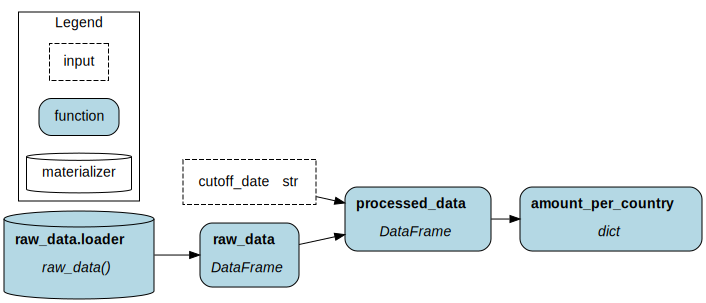

In [20]:
%%cell_to_module module_7 --display
import pandas as pd
from hamilton.function_modifiers import dataloader

DATA = {
    "cities": ["New York", "Los Angeles", "Chicago", "Montréal", "Vancouver", "Houston", "Phoenix", "Mexico City", "Chihuahua City", "Rio de Janeiro"],
    "date": ["2024-09-13", "2024-09-12", "2024-09-11", "2024-09-11", "2024-09-09", "2024-09-08", "2024-09-07", "2024-09-06", "2024-09-05", "2024-09-04"],
    "amount": [478.23, 251.67, 989.34, 742.14, 584.56, 321.85, 918.67, 135.22, 789.12, 432.78],
    "country": ["USA", "USA", "USA", "Canada", "Canada", "USA", "USA", "Mexico", "Mexico", "Brazil"],
    "currency": ["USD", "USD", "USD", "CAD", "CAD", "USD", "USD", "MXN", "MXN", "BRL"],
}

@dataloader()
def raw_data() -> tuple[pd.DataFrame, dict]:
    """Loading raw data. This simulates loading from a file, database, or external service."""
    data = pd.DataFrame(DATA)
    metadata = {"source": "notebook", "format": "json"}
    return data, metadata

def processed_data(raw_data: pd.DataFrame, cutoff_date: str) -> pd.DataFrame:
    """Filter out rows before cutoff date and convert currency to USD."""
    df = raw_data.loc[raw_data.date > cutoff_date].copy()
    df["amound_in_usd"] = df["amount"]
    df.loc[df.country == "Canada", "amound_in_usd"] *= 0.71  
    df.loc[df.country == "Brazil", "amound_in_usd"] *= 0.18
    df.loc[df.country == "Mexico", "amound_in_usd"] *= 0.05
    return df

def amount_per_country(processed_data: pd.DataFrame) -> dict:
    """Sum the amount in USD per country"""
    return processed_data.groupby("country")["amound_in_usd"].sum()

The visualization now displays the "materializer" node for the data loader. When we execute the dataflow, it behaves as expected.

raw_data.loader::adapter::execute_node
raw_data::adapter::execute_node
processed_data::result_store::get_result::hit
amount_per_country::result_store::get_result::hit



country
Brazil      77.9004
Canada     941.9570
Mexico      46.2170
USA       2959.7600
Name: amound_in_usd, dtype: float64



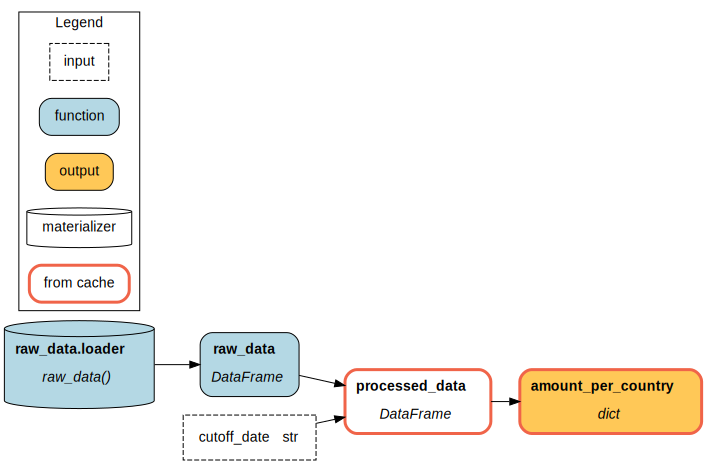

In [21]:
dr8 = driver.Builder().with_modules(module_7).with_cache().build()

results = dr8.execute(["amount_per_country"], inputs={"cutoff_date": "2024-09-01"})
print()
print(results["amount_per_country"].head())
print()
dr8.cache.view_run()

### Force recompute all
By using the special value `True` you can force all nodes to adopt a specific behavior. For instance, `.with_cache(recompute=True)` will force all nodes to be executed and don't retrieve anything. This is useful to produce a "cache refresh" with up-to-date values.

raw_data.loader::adapter::execute_node
raw_data::adapter::execute_node
processed_data::adapter::execute_node
amount_per_country::adapter::execute_node



country
Brazil      77.9004
Canada     941.9570
Mexico      46.2170
USA       2959.7600
Name: amound_in_usd, dtype: float64



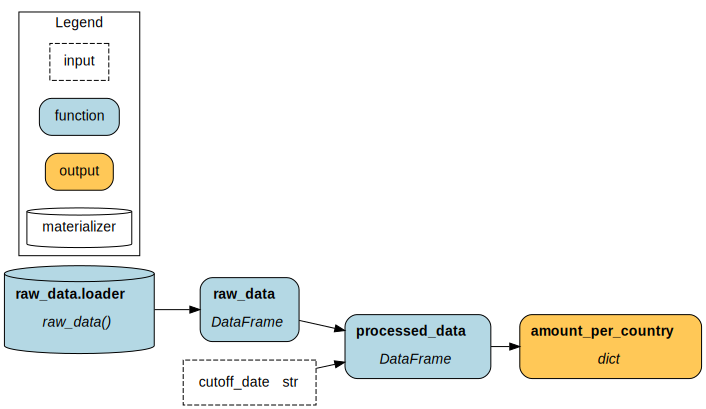

In [22]:
dr9 = driver.Builder().with_modules(module_7).with_cache(recompute=True).build()

results = dr9.execute(["amount_per_country"], inputs={"cutoff_date": "2024-09-01"})
print()
print(results["amount_per_country"].head())
print()
dr9.cache.view_run()

## Changing the cache format

By default, results are stored in ``pickle`` format. It's a convenient default but [comes with caveats](https://grantjenks.com/docs/diskcache/tutorial.html#caveats). The `@cache` decorator allows you to specify a more reliable file format. By default this includes:

- `json`
- `parquet`
- `csv`
- `excel`
- `file`
- `feather`
- `orc`

This feature uses `DataLoader` and `DataSaver` under the hood and supports all of the same formats (including your custom ones, as long as they take a `path` attribute).

> This is an area of active development. Feel free to share suggestions and feedback!

The next cell sets `processed_data` to be cached as `parquet`.

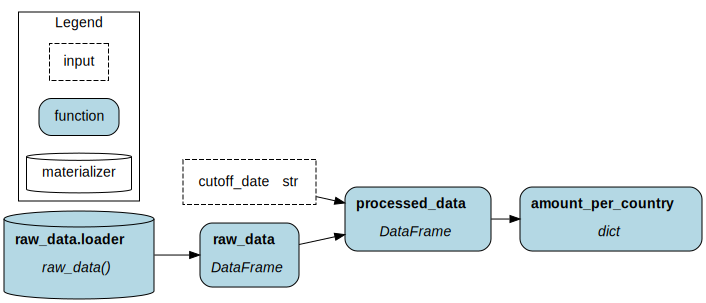

In [23]:
%%cell_to_module module_8 --display
import pandas as pd
from hamilton.function_modifiers import dataloader, cache

DATA = {
    "cities": ["New York", "Los Angeles", "Chicago", "Montréal", "Vancouver", "Houston", "Phoenix", "Mexico City", "Chihuahua City", "Rio de Janeiro"],
    "date": ["2024-09-13", "2024-09-12", "2024-09-11", "2024-09-11", "2024-09-09", "2024-09-08", "2024-09-07", "2024-09-06", "2024-09-05", "2024-09-04"],
    "amount": [478.23, 251.67, 989.34, 742.14, 584.56, 321.85, 918.67, 135.22, 789.12, 432.78],
    "country": ["USA", "USA", "USA", "Canada", "Canada", "USA", "USA", "Mexico", "Mexico", "Brazil"],
    "currency": ["USD", "USD", "USD", "CAD", "CAD", "USD", "USD", "MXN", "MXN", "BRL"],
}

@dataloader()
def raw_data() -> tuple[pd.DataFrame, dict]:
    """Loading raw data. This simulates loading from a file, database, or external service."""
    data = pd.DataFrame(DATA)
    metadata = {"source": "notebook", "format": "json"}
    return data, metadata

@cache(format="parquet")
def processed_data(raw_data: pd.DataFrame, cutoff_date: str) -> pd.DataFrame:
    """Filter out rows before cutoff date and convert currency to USD."""
    df = raw_data.loc[raw_data.date > cutoff_date].copy()
    df["amound_in_usd"] = df["amount"]
    df.loc[df.country == "Canada", "amound_in_usd"] *= 0.71  
    df.loc[df.country == "Brazil", "amound_in_usd"] *= 0.18
    df.loc[df.country == "Mexico", "amound_in_usd"] *= 0.05
    return df

def amount_per_country(processed_data: pd.DataFrame) -> dict:
    """Sum the amount in USD per country"""
    return processed_data.groupby("country")["amound_in_usd"].sum()

When executing the dataflow, we see `raw_data` recomputed because it's a dataloader. The result for `processed_data` will be retrieved, but it will be saved again as `.parquet` this time. 

raw_data.loader::adapter::execute_node
raw_data::adapter::execute_node
processed_data::adapter::execute_node
amount_per_country::result_store::get_result::hit



country
Brazil      77.9004
Canada     941.9570
Mexico      46.2170
USA       2959.7600
Name: amound_in_usd, dtype: float64



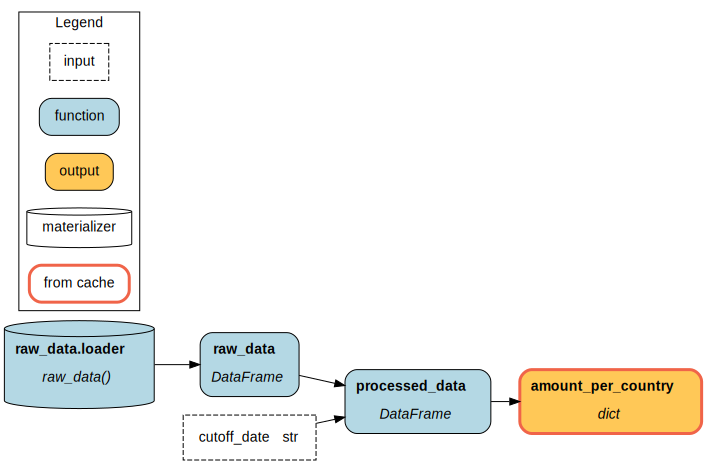

In [24]:
dr10 = driver.Builder().with_modules(module_8).with_cache().build()

results = dr10.execute(["amount_per_country"], inputs={"cutoff_date": "2024-09-01"})
print()
print(results["amount_per_country"].head())
print()
dr10.cache.view_run()

Now, under the `./hamilton_cache`, there will be two results of the same name, one with the `.parquet` extension and one without. The one without is actually a pickeld `DataLoader` to retrieve the `.parquet` file.

You can access the path programmatically via the `result_store._path_from_data_version(...)` method.

In [25]:
data_version = dr10.cache.data_versions[dr10.cache.last_run_id]["processed_data"]
parquet_path = dr10.cache.result_store._path_from_data_version(data_version).with_suffix(".parquet")
parquet_path.exists()

True

## Introspecting the cache
The `Driver.cache` stores information about all executions over its lifetime. Previous `run_id` are available through `Driver.cache.run_ids` and can be used in tandem without other utility functions:

- Resolve the node caching behavior (e.g., "recompute")
- Access structured logs
- Visualize the cache execution

Also, `Driver.cache.last_run_id` is a shortcut to the most recent execution.

In [26]:
dr9.cache.resolve_behaviors(dr9.cache.last_run_id)

{'amount_per_country': <CachingBehavior.RECOMPUTE: 2>,
 'processed_data': <CachingBehavior.RECOMPUTE: 2>,
 'raw_data.loader': <CachingBehavior.RECOMPUTE: 2>,
 'raw_data': <CachingBehavior.RECOMPUTE: 2>,
 'cutoff_date': <CachingBehavior.RECOMPUTE: 2>}

In [27]:
run_logs = dr9.cache.logs(dr9.cache.last_run_id, level="debug")
for event in run_logs["processed_data"]:
    print(event)

processed_data::adapter::resolve_behavior
processed_data::adapter::set_cache_key
processed_data::adapter::execute_node
processed_data::adapter::get_cache_key::hit
processed_data::adapter::set_data_version
processed_data::metadata_store::set_data_version
processed_data::adapter::get_cache_key::hit
processed_data::adapter::get_data_version::hit
processed_data::adapter::get_data_version::hit
processed_data::adapter::resolve_behavior


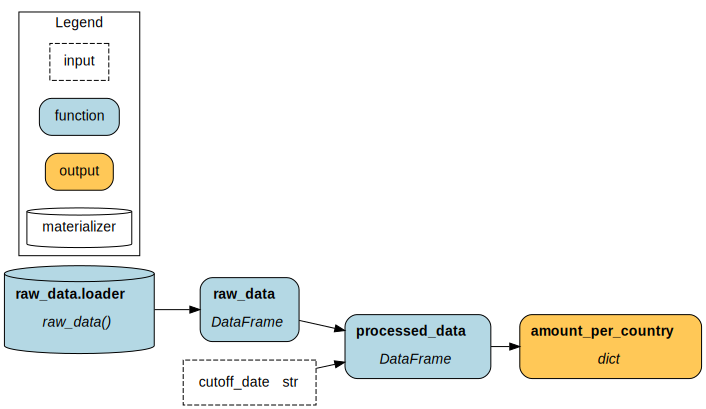

In [28]:
# for `.view_run()` passing no parameter is equivalent to the last `run_id`
dr9.cache.view_run(dr9.cache.last_run_id)

### Interactively explore runs
By using `ipywidgets` we can easily build a widget to iterate over `run_id` values and display cache information. Below, we create a `Driver` and execute it a few times to generate data then inspect it with a widget.

> The following cell allows you to click-and-drag or use arrow-keys to navigate

In [29]:
dr10 = driver.Builder().with_modules(module_7).with_cache().build()

dr10.execute(["amount_per_country"], inputs={"cutoff_date": "2024-09-01"})
dr10.execute(["amount_per_country"], inputs={"cutoff_date": "2024-09-05"})
dr10.execute(["amount_per_country"], inputs={"cutoff_date": "2024-09-10"})
dr10.execute(["amount_per_country"], inputs={"cutoff_date": "2024-09-11"})
dr10.execute(["amount_per_country"], inputs={"cutoff_date": "2024-09-13"})

raw_data.loader::adapter::execute_node
raw_data::adapter::execute_node
processed_data::result_store::get_result::hit
amount_per_country::result_store::get_result::hit
raw_data.loader::adapter::execute_node
raw_data::adapter::execute_node
processed_data::adapter::execute_node
amount_per_country::adapter::execute_node
raw_data.loader::adapter::execute_node
raw_data::adapter::execute_node
processed_data::adapter::execute_node
amount_per_country::adapter::execute_node
raw_data.loader::adapter::execute_node
raw_data::adapter::execute_node
processed_data::adapter::execute_node
amount_per_country::result_store::get_result::hit
raw_data.loader::adapter::execute_node
raw_data::adapter::execute_node
processed_data::adapter::execute_node
amount_per_country::adapter::execute_node


{'amount_per_country': Series([], Name: amound_in_usd, dtype: float64)}

In [30]:
from ipywidgets import interact, SelectionSlider
from IPython.display import display

@interact(run_id=SelectionSlider(options=dr10.cache.run_ids))
def iterate_over_runs(run_id):
    display(dr10.cache.data_versions[run_id])
    display(dr10.cache.view_run(run_id=run_id))

interactive(children=(SelectionSlider(description='run_id', options=('3a2b40cc-7683-42c0-ad69-6f2c926b7a69', '…

## Managing storage
### Setting the cache `path`

By default, metadata and results are stored under `./hamilton_cache`, relative to the current directory at execution time. You can also manually set the directory via `.with_cache(path=...)` to isolate or centralize cache storage between dataflows or projects.

Running the next cell will create the directory `./my_other_cache`.

In [31]:
dr11 = driver.Builder().with_modules(module_7).with_cache(path="./my_other_cache").build()

### Instantiating the `result_store` and `metadata_store`
If you need to store metadata and results in separate locations, you can do so by instantiating the `result_store` and `metadata_store` manually with their own configuration. In this case, setting `.with_cache(path=...)` would be ignored.

In [32]:
from hamilton.caching.stores.file import FileResultStore
from hamilton.caching.stores.sqlite import SQLiteMetadataStore

result_store = FileResultStore(path="./results")
metadata_store = SQLiteMetadataStore(path="./metadata")

dr12 = (
    driver.Builder()
    .with_modules(module_7)
    .with_cache(
        result_store=result_store,
        metadata_store=metadata_store,
    )
    .build()
)

### Deleting data and recovering storage
As you use caching, you might be generating a lot of data that you don't need anymore. One straightforward solution is to delete the entire directory where metadata and results are stored. 

You can also programmatically call `.delete_all()` on the `result_store` and `metadata_store`, which should reclaim most storage. If you delete results, make sure to also delete metadata. The caching mechanism should figure it out, but it's safer to keep them in sync.

In [33]:
dr12.cache.metadata_store.delete_all()
dr12.cache.result_store.delete_all()

## Usage patterns

As demonstrated here, caching works great in a notebook environment.

In addition to iteration speed, caching allows you to restart your kernel or shutdown your computer for the day without worry. When you'll come back, you will still be able to retrieve results from cache.

A similar benefit is the ability resume execution between environments. For example, you might be running Hamilton in a script, but when a bug happens you can reload these values in a notebook and investigate.

## 🚧 INTERNALS
If you're curious the following sections provide details about the caching internals. These APIs are not public and may change without notice.

### Manually retrieve results
Using the `Driver.cache` you can directly retrieve results from previous executions. The cache stores "data versions" which are keys for the `result_store`. 

Here, we get the `run_id` for the 4th execution (index 3) and the data version for `processed_data` before retrieving its value.

In [34]:
run_id = dr10.cache.run_ids[3]
data_version = dr10.cache.data_versions[run_id]["processed_data"]
result = dr10.cache.result_store.get(data_version)
print(result)

        cities        date  amount country currency  amound_in_usd
0     New York  2024-09-13  478.23     USA      USD         478.23
1  Los Angeles  2024-09-12  251.67     USA      USD         251.67


### Decoding the `cache_key`

By now, you should have a better grasp on how Hamilton's caching determines when to execute a node. Internally, it creates a `cache_key` from the `code_version` of the node and the `data_version` of each dependency. The cache keys are stored on the `Driver.cache` and can be decoded for introspection and debugging.

Here, we get the `run_id` for the 3rd execution (index 2) and the cache key for `amount_per_country`. We then use `decode_key()` to retrieve the `node_name`, `code_version`, and `dep_data_versions` (the dependencies data versions).

In [35]:
from hamilton.caching.cache_key import decode_key
run_id = dr10.cache.run_ids[2]
cache_key = dr10.cache.cache_keys[run_id]["amount_per_country"]
decode_key(cache_key)

{'node_name': 'amount_per_country',
 'code_version': 'bb7ed954f91a29433b476c7009d4d0b9003e68ac78bb4952c292f5be980da824',
 'dep_data_versions': {'processed_data': 'WgV5-4SfdKTfUY66x-msj_xXsKNPNTP2guRhfw=='}}

Indeed, this match the data version for `processed_data` for the 3rd execution.

In [36]:
dr10.cache.data_versions[run_id]["processed_data"]

'WgV5-4SfdKTfUY66x-msj_xXsKNPNTP2guRhfw=='

### Manually retrieve metadata

In addition to the `result_store`, there is a `metadata_store` that contains mapping between `cache_key` and `data_version` (cache keys are unique, but many can point to the same data).

Using the knowledge from the previous section, we can use the cache key for `amount_per_country` to retrieve its `data_version` and result. It's also possible to decode its `cache_key`, and get the `data_version` for its dependencies, making the node execution reproducible.

In [37]:
run_id = dr10.cache.run_ids[2]
cache_key = dr10.cache.cache_keys[run_id]["amount_per_country"]
amount_data_version = dr10.cache.metadata_store.get(cache_key)
amount_result = dr10.cache.result_store.get(amount_data_version)
print(amount_result)

country
Canada     526.9194
USA       1719.2400
Name: amound_in_usd, dtype: float64


In [38]:
for dep_name, dep_data_version in decode_key(cache_key)["dep_data_versions"].items():
    dep_result = dr10.cache.result_store.get(dep_data_version)
    print(dep_name)
    print(dep_result)
    print()

processed_data
        cities        date  amount country currency  amound_in_usd
0     New York  2024-09-13  478.23     USA      USD       478.2300
1  Los Angeles  2024-09-12  251.67     USA      USD       251.6700
2      Chicago  2024-09-11  989.34     USA      USD       989.3400
3     Montréal  2024-09-11  742.14  Canada      CAD       526.9194

